In [ ]:
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# Data Load

In [ ]:
df = pd.read_csv('/content/email.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5573 entries, 0 to 5572
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5573 non-null   object
 1   Message   5573 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


# Exploratory Data Analysis (EDA)

In [ ]:
df['Category'].unique()

array(['ham', 'spam', '{"mode":"full"'], dtype=object)

Ternyata setelah dicek terdapat kategori lain selain 'ham' dan 'spam'

In [ ]:
df[df['Category'] == '{"mode":"full"'].value_counts().sum()

1

Ternyata terdapat 1 data dengan kategori tersebut

In [ ]:
df[df['Category'] == '{"mode":"full"']['Message']

,Message
5572,isActive:false}


Setelah ditelusuri message dengan kategori tersebut tidak dapat dikategorikan ke 'spam' ataupun 'ham', mungkin ini adalah data yang error atau ada kesalahan pada proses pembuatan data, maka record tersebut bisa kita buang

In [ ]:
# drop data dengan category tertentu

df_new = df.drop(df[df['Category'] == '{"mode":"full"'].index)

<Axes: xlabel='Category'>

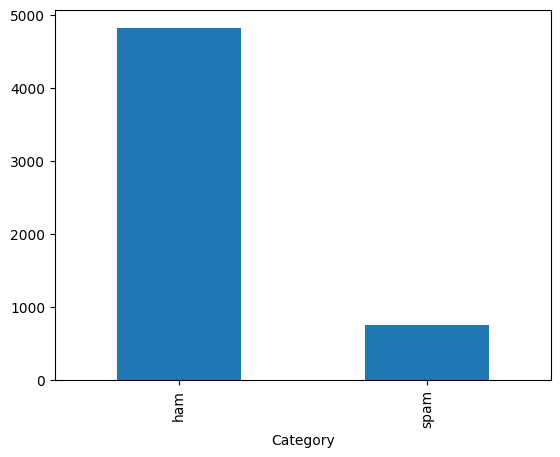

In [ ]:
# tampilkan distribusi data

df_new['Category'].value_counts().plot(kind='bar')

In [ ]:
# cek data null

df.isnull().sum()

,0
Category,0
Message,0


Tidak terdapat data  null

In [ ]:
# membuat fitur untuk panjang kata

df_new['Length'] = df_new['Message'].str.len()

In [ ]:
# membuat fitur untuk banyak tautan

df_new['Link'] = df_new['Message'].str.count('http')

In [ ]:
df_new.describe()

,Length,Link
count,5572.000000,5572.000000
mean,80.368988,0.003769
std,59.926946,0.061281
min,2.000000,0.000000
25%,35.750000,0.000000
50%,61.000000,0.000000
75%,122.000000,0.000000
max,910.000000,1.000000


Ternyata panjang data terpendek adalah hanya 2 karakter, perlu dilakukan penelusuran kembali

In [ ]:
df_new[df_new['Length'] == 2]['Message']

,Message
1925,Ok
3051,Ok
3376,:)
4498,Ok
5357,Ok


Ternyata text singkat ini adalah seperti balasan pesan pada umumnya dan bukan suatu data anomali maka dibiarkan

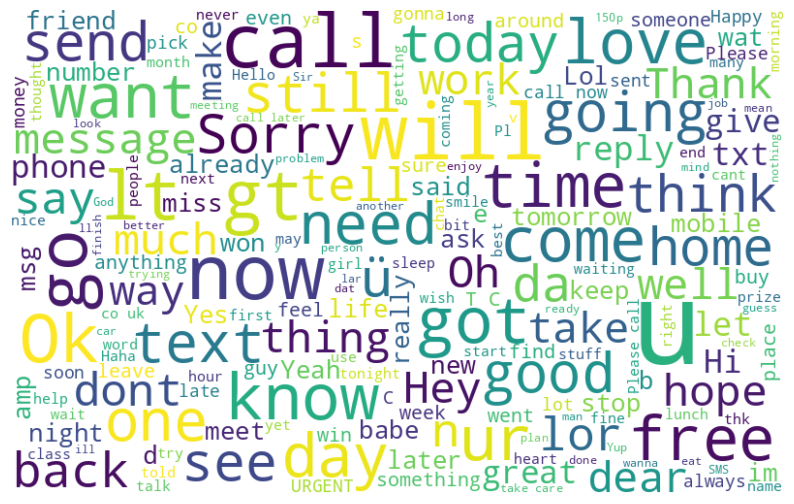

In [ ]:
def wordCloud(words):
    wordCloud = WordCloud(width=800, height=500, background_color='white', random_state=21, max_font_size=120).generate(words)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.axis('off')

all_words = ' '.join([text for text in df_new['Message']])
wordCloud(all_words)

In [ ]:
# ubah target menjadi numeric
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_new['Category_Numeric'] = label_encoder.fit_transform(df_new['Category'])

Text(0.5, 1.0, 'Correlation Matrix untuk Fitur Numerik ')

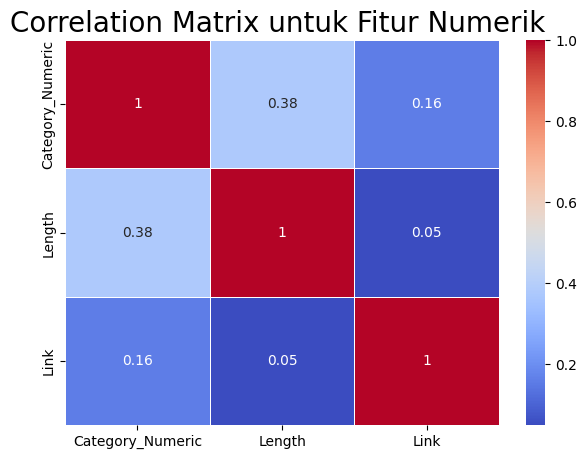

In [ ]:
# cek korelasi antara fitur numerik terhadap target

numerical_features = ['Category_Numeric', 'Length', 'Link']

plt.figure(figsize=(7, 5))
correlation_matrix = df_new[numerical_features].corr().round(2)

sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, )
plt.title("Correlation Matrix untuk Fitur Numerik ", size=20)

Setelah dicek antara fitur numerik, yaitu keduanya memiliki korelasi positif terhadap target namun korelasinya cukup lemah (mendekati nilai 0)

## Data Preparation

In [ ]:
# split data menjadi data train dan data test

from sklearn.model_selection import train_test_split

train, test = train_test_split(df_new, test_size=0.2, random_state=42)

In [ ]:
train.shape

(4457, 5)

In [ ]:
test.shape

(1115, 5)

In [ ]:
# implementasi tf-idf pada text

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)

train_vectors = vectorizer.fit_transform(train['Message']).toarray()
test_vectors = vectorizer.transform(test['Message']).toarray()

additional_features = train[['Length', 'Link']].values
test_additional_features = test[['Length', 'Link']].values

X_train = np.hstack([train_vectors, additional_features])
X_test = np.hstack([test_vectors, test_additional_features])

In [ ]:
X_train.shape

(4457, 1547)

In [ ]:
X_test.shape

(1115, 1547)

In [ ]:
y_train = train["Category"]
y_test = test["Category"]

## Model

In [ ]:
from sklearn import svm
from sklearn.metrics import classification_report

classifier = svm.SVC(kernel='linear')
classifier.fit(X_train, y_train)

SVC(kernel='linear')

In [ ]:
predictions = classifier.predict(X_test)

target_names = ['spam', 'ham']
print(classification_report(y_test, predictions, target_names=target_names))

              precision    recall  f1-score   support

        spam       0.99      1.00      0.99       966
         ham       1.00      0.93      0.96       149

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.98      1115
weighted avg       0.99      0.99      0.99      1115



## Inference

In [ ]:
def predict_spam(classifier, text):
    # Preprocessing teks yang akan diinferensikan
    length = len(text)
    link_count = text.count('http')

    text_vector = vectorizer.transform([text]).toarray()
    additional_features = np.array([[length, link_count]])

    X_input = np.hstack([text_vector, additional_features])

    # Prediksi menggunakan model yang telah dilatih
    prediction = classifier.predict(X_input)

    return prediction

In [ ]:
teks = """Congratulations! You are the lucky winner of $1,000,000! To claim your prize, click the link below and fill out your details. Claim Now Hurry, this offer expires soon!"""
prediction = predict_spam(classifier, teks)
print(prediction)

['spam']


In [ ]:
teks = """Sorry, can you call me by tomorrow morning?"""
prediction = predict_spam(classifier, teks)
print(prediction)

['ham']
